In [1]:
import sys
import os
import pickle
import random
import copy

from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib.colors import ListedColormap


from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

sys.path.append('../../settings/')
import settings

sys.path.append('../common/')
import data_io_utils
import plot_style_utils

import A007_common

%reload_ext autoreload
%autoreload 2

sns.reset_defaults()


np.random.seed(1)
random.seed(1)

In [2]:
AGGREGATED_MUTANT_DATA_DIR = os.path.join(A007_common.MLPE_GFP_DATA_DIR, 
        'Clean_FPbase_aggregated_parents_and_mutant_dfs')
data_io_utils.sync_s3_path_to_local(AGGREGATED_MUTANT_DATA_DIR)

In [3]:
DROP_EVOTUNE_DUPLICATES=True

if DROP_EVOTUNE_DUPLICATES:
    DUP_DF = pd.read_csv(os.path.join(AGGREGATED_MUTANT_DATA_DIR, 'Fig5_Aequorea_GFPs_not_in_evotrain_actual.csv'), 
            index_col=0)
    display(DUP_DF.head()) # Keep these sequences in the generalization set.

,name,seq
0,W1C,MASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...
1,GFP-151pyTyrCu,MSKGAELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,GFP-Tyr151pyz,MSKGEALFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,P4-1,MASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...
7,cpCitrine,MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...


### Plotting context

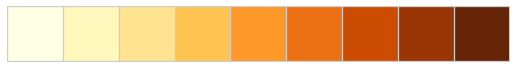

In [4]:
plot_style_utils.set_pub_plot_context(context="talk", colors="sequential")
sns.palplot(sns.color_palette())
seq_colors = sns.color_palette()
MPL_CMAP = ListedColormap(sns.color_palette().as_hex())


AXMIN = -0.5
AXMAX = 1.4
CLIM = [0, 21]

## Empirical distribution for Sarkisyan avGFP

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


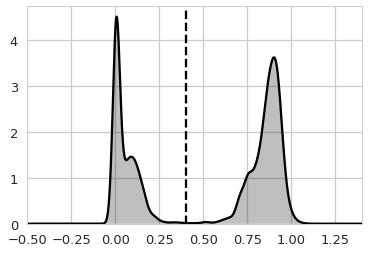

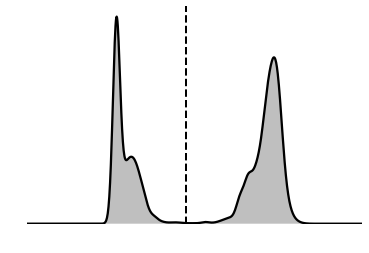

In [5]:
EXAMPLE_SARK_BF_TTS_SPLIT = np.load(
    os.path.join(A007_common.MLPE_GFP_DATA_DIR, 'gfp_avg_hidden_sark_bf_fixed_rep_tts.npz'))
empirical_avGFP_brightnesses = EXAMPLE_SARK_BF_TTS_SPLIT['Y_train']
empirical_avGFP_brightnesses = np.concatenate((empirical_avGFP_brightnesses, np.array([AXMIN, AXMAX])))
EMPIRICAL_THRESHOLD = 0.4

plt.figure()
sns.kdeplot(empirical_avGFP_brightnesses, bw=0.05, color='k', shade=True, gridsize=1000)
plt.axvline(EMPIRICAL_THRESHOLD, ls='--', color='k')
plt.xlim(AXMIN, AXMAX)
#plt.axis('off')
plt.show()

fig = plt.figure()
sns.kdeplot(empirical_avGFP_brightnesses, bw=0.05, color='k', shade=True, gridsize=1000)
plt.axvline(EMPIRICAL_THRESHOLD, ls='--', color='k', linewidth=2)
plt.xlim(AXMIN, AXMAX)
plt.axis('off')
plt.show()

plot_style_utils.save_for_pub(fig, path='figure_related/sarkisyan_empirical_dist', dpi=300)

## Predicted v actual plots for FPbase sequences.

In [6]:
REPS = ['pbab', 'random1', 'finetune1']
REPNAMES = ['UniRep', 'Random init.', 'Evotuned UniRep']
def pred_jitter_data_for_reps():
    
    rep2repname = {}
    for i,r in enumerate(REPS):
        rep2repname[r] = REPNAMES[i]
        
    nmuts = []
    pred_bright = []
    rep_names = []
    is_neg = []
    for representation in REPS:
    
        # Aggregated mutant data
        NEG_MUT_NUM = 6.0
        NEG_MUT_DOWNSAMPLE = 1000
        agg_mutant_df = pd.read_csv(os.path.join(AGGREGATED_MUTANT_DATA_DIR, representation + '.csv'))
        agg_mutant_df_neg = agg_mutant_df[agg_mutant_df['num_mutations'] == NEG_MUT_NUM].reset_index()
        agg_mutant_df = agg_mutant_df[agg_mutant_df['num_mutations'] == 0.0]
        
        # Downsample negative mutants
        pidx = np.random.permutation(agg_mutant_df_neg.shape[0])
        agg_mutant_df_neg = agg_mutant_df_neg.iloc[pidx[:NEG_MUT_DOWNSAMPLE]]
        
        agg_mutant_df_neg.shape
        # Link it with fpbase metadata, including aligned sequences so we can calculat # mutations
        # relative to avGFP.
        fpbase_metadata_file = os.path.join(A007_common.MLPE_GFP_DATA_DIR,
                'fps_and_pdb', 
                '20181011_fp_database_length_filtered_outliers_filtered_internal_sfGFP_avGFP_alignment_manual_protein_tag_removal_Met_added_metadata.txt'
        )
        data_io_utils.sync_s3_path_to_local(fpbase_metadata_file, is_single_file=True)
        fpbase_md_df = pd.read_csv(fpbase_metadata_file)
        fpbase_md_df.rename(columns={'name': 'parent'}, inplace=True)
        
        agg_mutant_md_df = pd.merge(agg_mutant_df, fpbase_md_df, on='parent', how='left')
        
        if DROP_EVOTUNE_DUPLICATES:
            ids_to_keep = list(DUP_DF['name']) + ['avGFP_internal', 'sfGFP_internal']
            fpbase_md_df = fpbase_md_df[fpbase_md_df['parent'].apply(lambda x: x in ids_to_keep)]
            agg_mutant_md_df = agg_mutant_md_df[agg_mutant_md_df['parent'].apply(lambda x: x in ids_to_keep)]
            

        avGFP_idx = int(np.argwhere(agg_mutant_md_df['parent'] == 'avGFP_internal'))
        ld_mat = A007_common.levenshtein_distance_matrix(list(agg_mutant_md_df['aln_seq']))
        NMUTS_REL_AVGFP = ld_mat[avGFP_idx]
        
        nmuts += list(NMUTS_REL_AVGFP)
        nmuts += [np.nan]*agg_mutant_df_neg.shape[0]
        pred_bright += list(agg_mutant_md_df['pred_brightness'])
        pred_bright += list(agg_mutant_df_neg['pred_brightness'])
        is_neg += list(list(np.zeros(len(NMUTS_REL_AVGFP)).astype(bool)))
        is_neg += list(list(np.ones(agg_mutant_df_neg.shape[0]).astype(bool)))
        rep_names += ([rep2repname[representation]]*len(NMUTS_REL_AVGFP) + 
                      [rep2repname[representation]]*agg_mutant_df_neg.shape[0])
        
    
    df = pd.DataFrame()
    df['rep_names'] = rep_names
    df['pred_brightness'] = pred_bright
    df['nmuts'] = nmuts
    df['is_neg'] = is_neg
    
    return df

        
    

In [7]:
jitter_df = pred_jitter_data_for_reps()

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


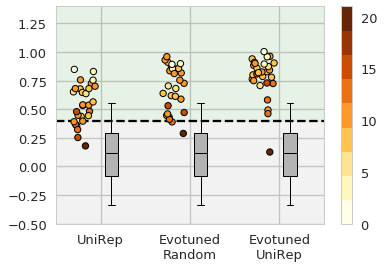

In [8]:
np.random.seed(1)
random.seed(1)

fig = plt.figure(figsize=plot_style_utils.STANDARD_FIG_SIZE)
plt.axhline(EMPIRICAL_THRESHOLD, ls='--', color='k')
plt.gca().axhspan(EMPIRICAL_THRESHOLD, AXMAX, alpha=0.1, color='green')
plt.gca().axhspan(AXMIN, EMPIRICAL_THRESHOLD, alpha=0.1, color='grey')

for i,rn in enumerate(REPNAMES):
    mask = np.logical_and(jitter_df['rep_names'] == rn, ~jitter_df['is_neg'])
    neg_mask = np.logical_and(jitter_df['rep_names'] == rn, jitter_df['is_neg'])
    
    x = 0.25*(np.random.rand(int(np.sum(mask)))-0.5) + i
    x_neg = 0.25*(np.random.rand(int(np.sum(~mask)))-0.5) + i
    
    bp = plt.boxplot(jitter_df['pred_brightness'][~mask], positions=[i+0.12], whis=0.7, patch_artist=True)
    for patch in bp['boxes']:
        patch.set(facecolor=[0.7, 0.7, 0.7])   
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='k')
    
    plt.scatter(x-0.18, jitter_df['pred_brightness'][mask], c=jitter_df['nmuts'][mask],
                edgecolor='k', linewidth=1, cmap=MPL_CMAP, s=40, zorder=5)
    #plt.boxplot(jitter_df['pred_brightness'][mask], positions=[i], whis=1.0)
    
    
plt.ylim(AXMIN, AXMAX)
plt.xlim(-0.5, 2.5)
cbar = plt.colorbar(ticks=np.arange(0,21,5))
plt.xticks([0,1,2])
plt.gca().set_xticklabels(['UniRep', 'Evotuned\nRandom', 'Evotuned\nUniRep'])
plt.clim(CLIM)

plot_style_utils.save_for_pub(fig, 
        path='figure_related/predicted_brightness_jitter_dedup-' + str(DROP_EVOTUNE_DUPLICATES), 
        dpi=300)